# [CorEx trials](#corex-trials)

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
from time import time
from IPython.display import display

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as ss
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets

In [3]:
%aimport src.visualization_helpers
from src.visualization_helpers import altair_datetime_heatmap, plot_horiz_bar

In [4]:
SMALL_SIZE = 26
MEDIUM_SIZE = 28
BIGGER_SIZE = 30
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.facecolor"] = "white"
sns.set_style("darkgrid", {"legend.frameon": False})
sns.set_context("talk", font_scale=0.95, rc={"lines.linewidth": 2.5})

In [5]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
%matplotlib inline

<a id="toc"></a>

## [Table of Contents](#table-of-contents)
0. [About](#about)
1. [User Inputs](#user-inputs)
2. [Load joined data](#load-joined-data)
3. [Create analysis model](#create-analysis-model)
4. [Topic modeling](#topic-modeling)
5. [Exploring topics combined with source data](#exploring-topics-combined-with-source-data)

<a id="about"></a>

## 0. [About](#about)

In this notebook, we will experiment with NLP models using CorEx on the joined news listings data in `data/processed/*_processed.csv`

<a id="user-inputs"></a>

## 1. [User Inputs](#user-inputs)

We'll define below the variables that are to be used throughout the code.

In [6]:
PROJ_ROOT_DIR = os.path.abspath(os.getcwd())
processed_data_dir = os.path.join(PROJ_ROOT_DIR, "data", "processed")

In [7]:
# Dataset
publication_name = "guardian"
cloud_run = False

# Data locations
data_dir_path = os.path.join(processed_data_dir, f"{publication_name}_processed.csv")

# Topic naming
mapping_dict = {
    "nytimes": {
        "component_1": "Academia",
        "component_2": "Shuttle Missions (no Crashes)",
        "component_3": "Digital",
        "component_4": "Mars Exploration",
        "component_5": "Imaging Stars - Astronomy",
        "component_6": "Rocket Launches - Testing and Moon Landing",
        "component_7": "Dark Matter theories",
        "component_8": "Planetary Research",
        "component_9": "Space Funding Bodies",
        "component_10": "ISS - USA and Russian segments",
        "component_11": "Gravity and Black Holes - Hawking",
        "component_12": "Global Warming",
        "component_13": "Studying Comets and Meteors (by children)",
        "component_14": "Soviet Union Spy Satellites",
        "component_15": "Discover of Sub-Atomic particles",
    },
    "guardian": {
        "component_1": "Academia",
        "component_2": "ISS - USA and Russian segments",
        "component_3": "Mars Exploration",
        "component_4": "Imaging Stars - Astronomy",
        "component_5": "Studying Comets and Meteors",
        "component_6": "Discover of Sub-Atomic particles",
        "component_7": "Rocket Launches - Moon Landing",
        "component_8": "Shuttle Missions and Crashes",
        "component_9": "Saturn Research",
        "component_10": "Space Funding Bodies",
        "component_11": "Objects crashing into Earth",
        "component_12": "Gravity and Black Holes - Hawking",
        "component_13": "Rocket Launches - Testing",
        "component_14": "Pluto Research",
        "component_15": "Global Warming",
    },
}

# CorEx inputs
corex_anchors = {
    "nytimes": [
        ["research", "science", "university"],
        ["space", "shuttle", "mission", "launch", "astronaut"],
        ["computer", "disk", "software", "memory"],
        ["mars", "rover", "life"],
        ["stars", "galaxy", "telescope"],
        ["moon", "lunar", "rocket", "nasa", "spacex"],
        ["universe", "theory", "matter"],
        ["planet", "solar", "spacecraft", "asteroid"],
        ["science", "research", "budget", "education"],
        ["station", "space", "mir", "nasa"],
        ["black", "hole", "hawking", "gravity"],
        ["warming", "climate", "ice", "carbon"],
        ["comet", "meteor", "halley"],
        ["soviet", "satellite", "weapons"],
        ["particles", "quantum", "neutrino", "theory"],
    ],
    "guardian": [
        ["people", "science", "brain"],
        ["station", "space", "mir", "nasa"],
        ["mars", "rover", "life"],
        ["stars", "galaxy", "telescope", "astronomer"],
        ["comet", "meteor", "lander", "dust"],
        ["particles", "higgs", "collider", "matter"],
        ["moon", "lunar", "rocket", "nasa", "apollo"],
        ["space", "shuttle", "mission", "launch", "crash", "astronaut"],
        ["cassini", "titan", "saturn"],
        ["science", "research", "budget", "education"],
        ["rock", "collision", "earth", "asteroid", "impact"],
        ["black", "hole", "universe", "gravity"],
        ["space", "launch", "rocket", "nasa", "spacex"],
        ["pluto", "horizons", "dwarf"],
        ["warming", "climate", "ice", "carbon"],
    ],
}
corex_anchor_strength = 4

# General inputs
n_topics_wanted = len(corex_anchors[publication_name])
number_of_words_per_topic_to_show = 10

<a id="load-joined-data"></a>

## 2. [Load joined data](#load-joined-data)

We'll start by loading the joined data from from a publication, stored at `data/processed/<publication-name>_processed.csv`, into a `DataFrame`

In [9]:
df = pd.read_csv(data_dir_path)
df = df[["text", "year"]]
display(df.head())

,text,year
0,The second Russian satellite has demonstrated ...,1957
1,"Col. Glenn reported ""hale and hearty""Picked up...",1962
2,The entire three-man crew of the Apollo One sp...,1967
3,Russia's celebratory gesture in manned space f...,1967
4,Men are on the moon. At 3 39 a.m. this morning...,1969


In [10]:
corpus = df.loc[:, "text"].values.tolist()

<a id="create-analysis-model"></a>

## 3. [Create analysis model](#create-analysis-model)

For a vectorizer, we will instantiate 1 option for tokenization
- `vectorizer`
  - this will use the string tokenization built in to [`scikit-learn`'s `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

In [11]:
vectorizer = CountVectorizer(
    tokenizer=None,
    stop_words="english",  # "all_stop_words" or "english"
    lowercase=True,
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    max_features=20000,
    binary=True,
    strip_accents="ascii",
    token_pattern="\\b[a-z][a-z]+\\b",
)

<a id="topic-modeling"></a>

## 4. [Topic modeling](#topic-modeling)

Next, we'll use the NLP analysis model to retrieve topics from the corpus

In [12]:
doc_word = vectorizer.fit_transform(corpus)
words = list(np.asarray(vectorizer.get_feature_names()))

In [13]:
topic_model = ct.Corex(
    n_hidden=n_topics_wanted, words=words, max_iter=200, verbose=False, seed=1
)

In [14]:
cell_st = time()

topic_model.fit(
    doc_word,
    words=words,
    docs=corpus,
    anchors=corex_anchors[publication_name],
    anchor_strength=corex_anchor_strength,
)

total_minutes, total_seconds = divmod(time() - cell_st, 60)
print(
    f"Cell exection time: {int(total_minutes):d} minutes, {total_seconds:.2f} seconds"
)

Cell exection time: 1 minutes, 36.37 seconds


Next, we'll print all topics found from the CorEx topic model

In [15]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(stop_words="english")
# model = model = NMF(n_components=n_topics_wanted, init="random", random_state=0)
# doc_word = vectorizer.fit_transform(corpus)
# doc_topic = model.fit_transform(doc_word)
# topic_word = pd.DataFrame(
#     model.components_.round(3),
#     index=[f"component_{k+1}" for k in range(n_topics_wanted)],
#     columns=vectorizer.get_feature_names(),
# )
# topic_word

In [16]:
df_row_list = []
for topic_num in range(1, n_topics_wanted + 1):
    df_row_topic_words = (
        pd.DataFrame.from_records(
            topic_model.get_topics(n_words=10, topic=topic_num - 1),
            columns=["Word", f"component_{topic_num}"],
        )
        .round(3)
        .set_index("Word")
        .T
    )
    df_row_list.append(df_row_topic_words)
topic_word = pd.concat(df_row_list, axis=0, sort=False).fillna(0)
# topic_word.index = topic_word.index.to_series().map(mapping_dict[publication_name])
# display(topic_word)

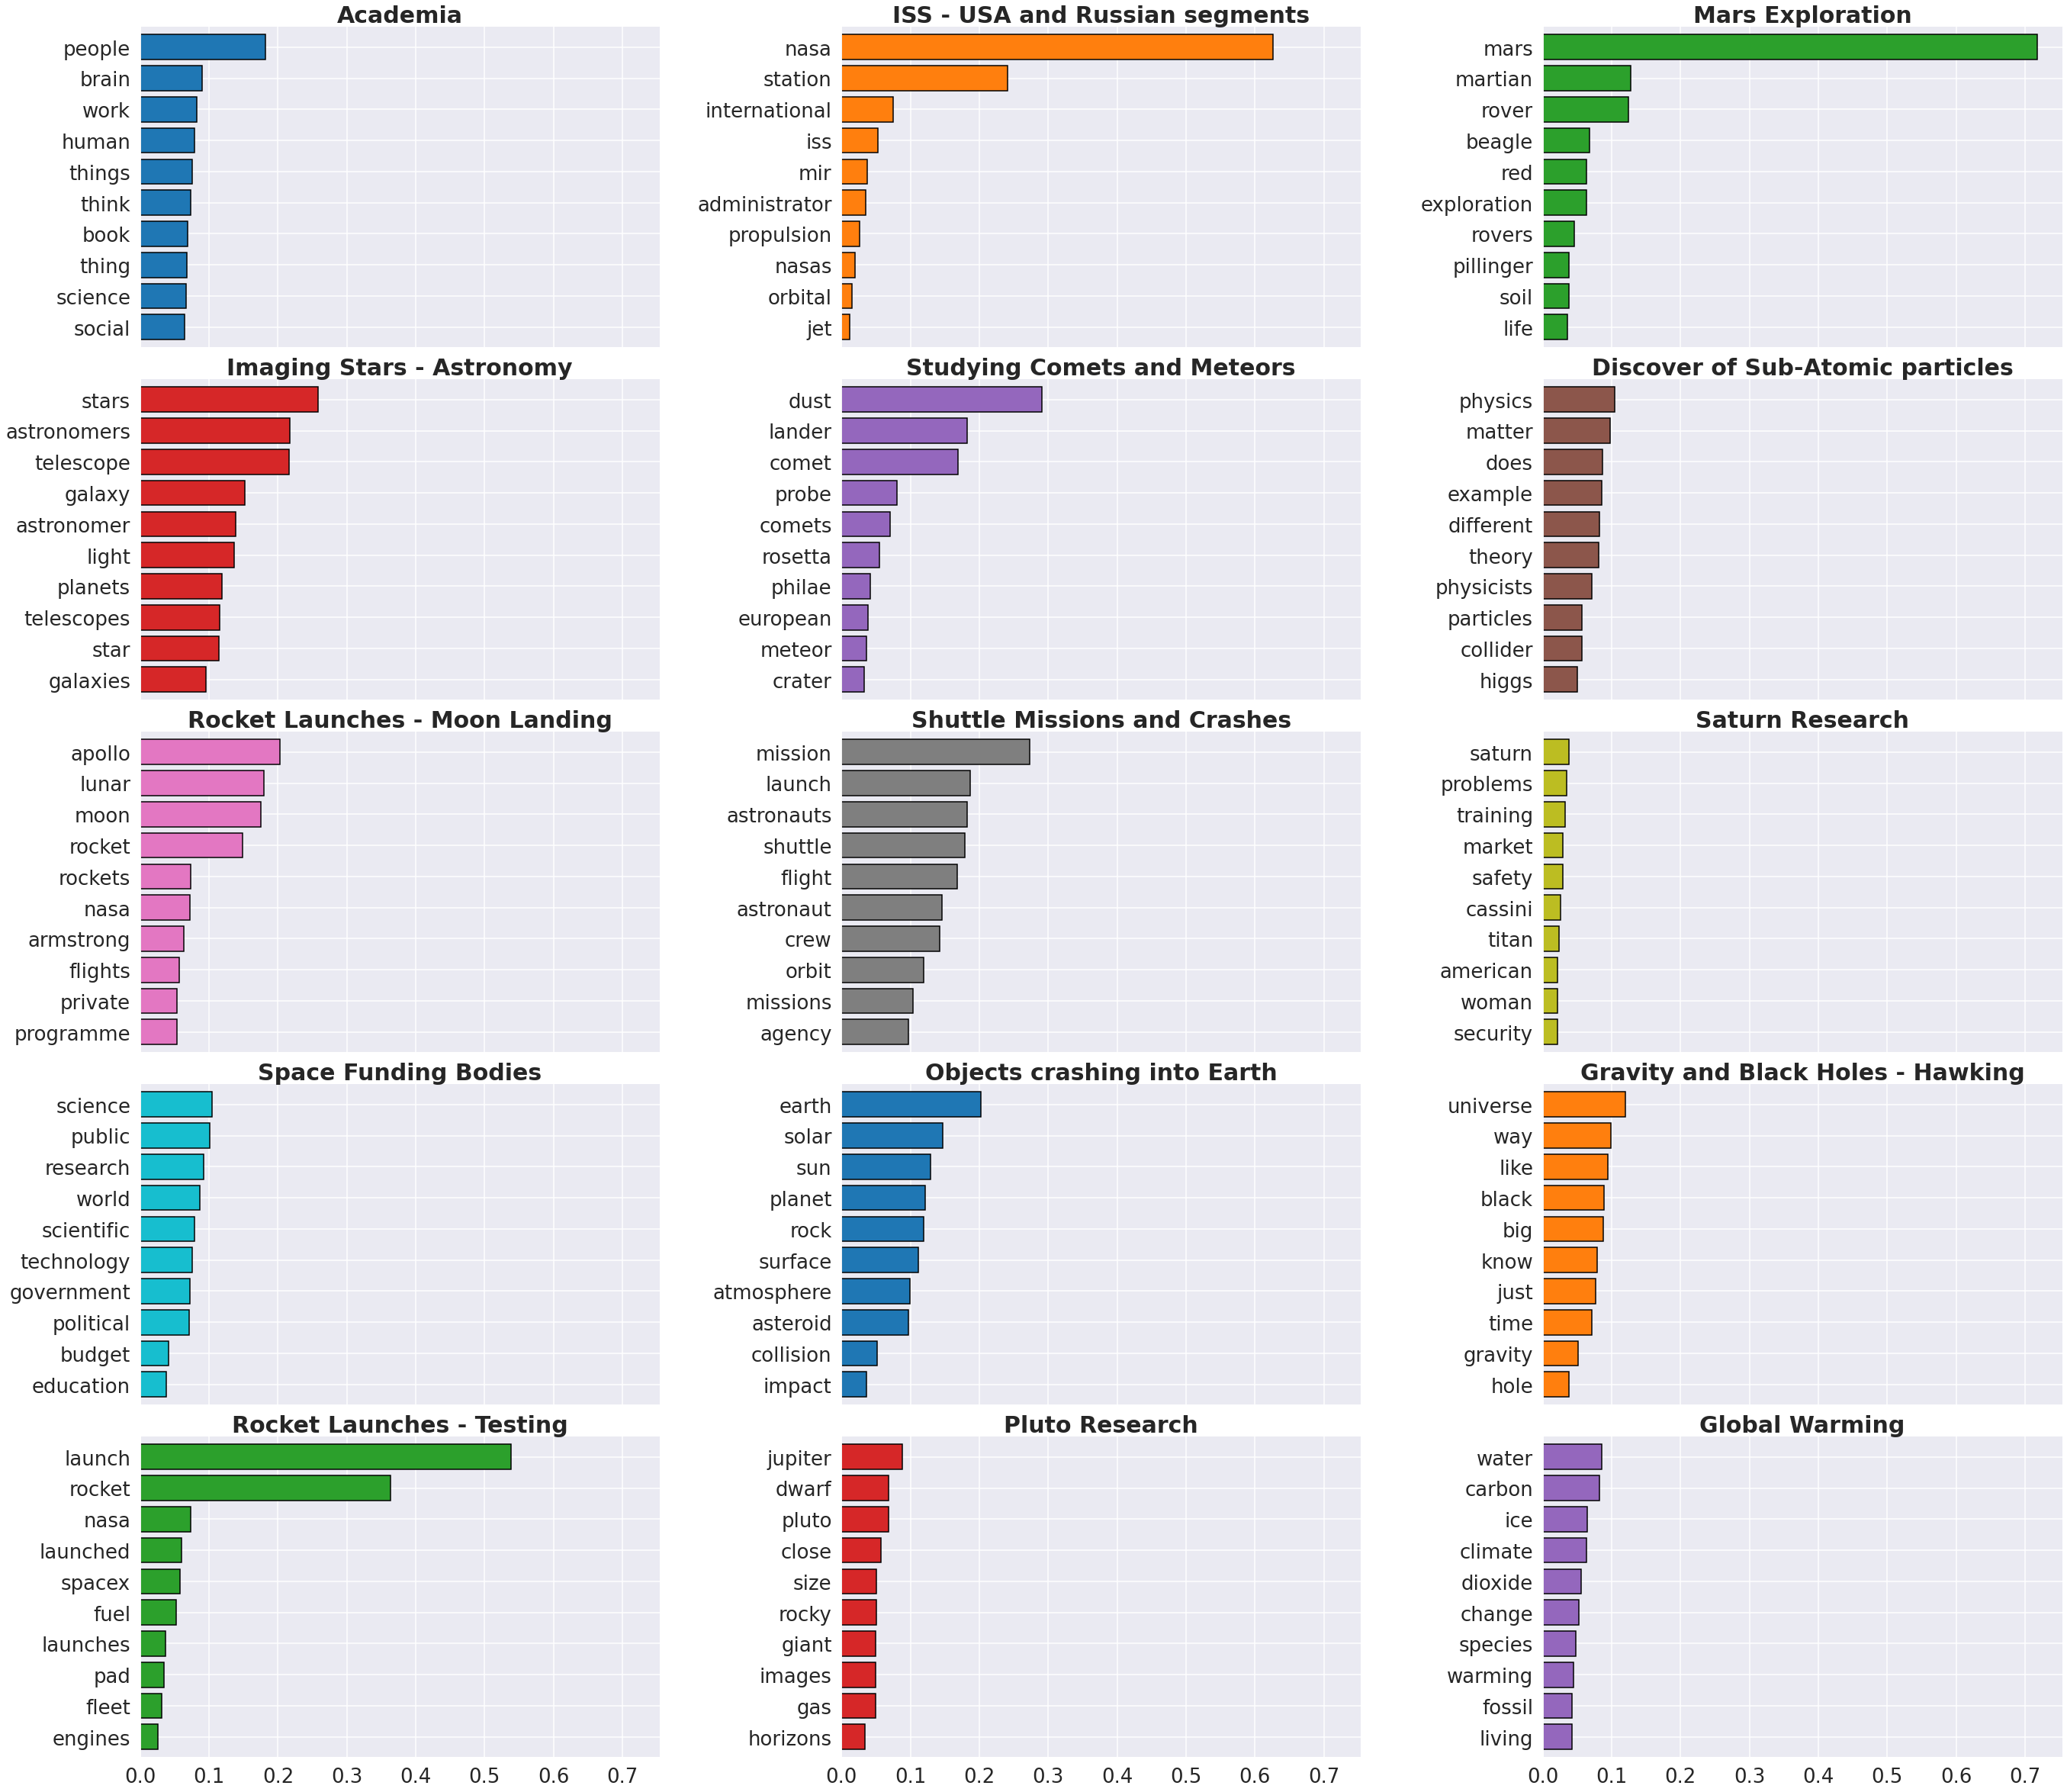

In [17]:
if not cloud_run:
    fig = plot_horiz_bar(
        topic_word.T,
        ptitle=[f"Topic {k+1}" for k in range(n_topics_wanted)],
        y_tick_mapper_list=list(mapping_dict[publication_name].values()),
        fig_size=(37, 6),
        xspacer=0.001,
        yspacer=0.3,
        ytick_font_size=18,
        title_font_size=20,
        annot_font_size=16,
        n_bars=number_of_words_per_topic_to_show,
        n_plots=topic_word.T.shape[1],
        n_cols=n_topics_wanted,
        show_bar_labels=False,
    )
    fig

**Observations**
1. The `Saturn Research` topic name appears a weaker assignment here for the Guardian than using NMF in `4_nlp_trials.ipynb`. The other topics appear reasonably well distinguished from eachother in the widths of the bars in the chart and from the words (bar labels) themselves.

In [18]:
cell_st = time()

if not cloud_run:
    fig.savefig(
        os.path.join(
            PROJ_ROOT_DIR,
            "reports",
            "figures",
            f"{publication_name}_nmf_topics_corex.png",
        ),
        bbox_inches="tight",
        dpi=300,
    )

total_minutes, total_seconds = divmod(time() - cell_st, 60)
print(
    f"Cell exection time: {int(total_minutes):d} minutes, {total_seconds:.2f} seconds"
)

Cell exection time: 0 minutes, 21.55 seconds


In [19]:
topics = topic_model.get_topics(n_words=10)
topic_words_dict = {}
for n, topic in enumerate(topics):
    topic_words, _ = zip(*topic)
    topic_words_dict[n] = topic_words
    print(f"{n+1}: {', '.join(topic_words)}")

1: people, brain, science, work, human, things, think, book, thing, social
2: nasa, station, mir, international, iss, administrator, propulsion, nasas, orbital, jet
3: mars, rover, life, martian, beagle, red, exploration, rovers, pillinger, soil
4: stars, telescope, galaxy, astronomer, astronomers, light, planets, telescopes, star, galaxies
5: dust, lander, comet, meteor, probe, comets, rosetta, philae, european, crater
6: matter, particles, collider, higgs, physics, does, example, different, theory, physicists
7: apollo, lunar, moon, rocket, nasa, rockets, armstrong, flights, private, programme
8: mission, launch, shuttle, astronaut, astronauts, flight, crew, orbit, missions, agency
9: saturn, cassini, titan, problems, training, safety, market, american, security, woman
10: science, research, budget, education, public, world, scientific, technology, government, political
11: earth, rock, asteroid, collision, solar, impact, sun, planet, surface, atmosphere
12: universe, black, gravity,

In [20]:
df_topics = pd.DataFrame.from_dict(topic_words_dict, orient="index")
df_topics.index = [f"topic {i+1}" for i in range(n_topics_wanted)]
df_topics.columns = [f"word {i+1}" for i in range(df_topics.shape[1])]
df_topics

,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9,word 10
topic 1,people,brain,science,work,human,things,think,book,thing,social
topic 2,nasa,station,mir,international,iss,administrator,propulsion,nasas,orbital,jet
topic 3,mars,rover,life,martian,beagle,red,exploration,rovers,pillinger,soil
topic 4,stars,telescope,galaxy,astronomer,astronomers,light,planets,telescopes,star,galaxies
topic 5,dust,lander,comet,meteor,probe,comets,rosetta,philae,european,crater
topic 6,matter,particles,collider,higgs,physics,does,example,different,theory,physicists
topic 7,apollo,lunar,moon,rocket,nasa,rockets,armstrong,flights,private,programme
topic 8,mission,launch,shuttle,astronaut,astronauts,flight,crew,orbit,missions,agency
topic 9,saturn,cassini,titan,problems,training,safety,market,american,security,woman
topic 10,science,research,budget,education,public,world,scientific,technology,government,political


In [21]:
predictions = pd.DataFrame(
    topic_model.predict(doc_word),
    columns=[
        # f"topic {i+1}: {', '.join(all_topic_words)}"
        f"component_{i+1}"
        for i, all_topic_words in topic_words_dict.items()
    ],
)
predictions = predictions.rename(columns=mapping_dict[publication_name])

In [22]:
df_predictions = df[["text", "year"]].merge(
    predictions, how="inner", left_index=True, right_index=True
)

In [23]:
# Get all topics per document
topics_per_row = df_predictions[df_predictions == True].stack().index.tolist()
df_topics_per_row = pd.DataFrame(topics_per_row).set_index(0)
df_topics_per_row.columns = ["topic"]
df_predictions = df_predictions.merge(
    df_topics_per_row, how="inner", left_index=True, right_index=True
)

In [24]:
df_predictions["topic"].value_counts().to_frame()

,topic
Saturn Research,2231
ISS - USA and Russian segments,1995
Shuttle Missions and Crashes,1515
Objects crashing into Earth,1456
Rocket Launches - Testing,1411
Academia,1331
Space Funding Bodies,1305
Gravity and Black Holes - Hawking,1279
Global Warming,1181
Rocket Launches - Moon Landing,1066


<a id="exploring-topics-combined-with-source-data"></a>

## 5. [Exploring topics combined with source data](#exploring-topics-combined-with-source-data)

Here, we will show a heatmap of the most popular topic by year

In [25]:
topics_by_timeframe = (
    df_predictions.groupby(["topic", "year"])
    .size()
    .reset_index()
    .sort_values(by=["topic", 0, "year"], ascending=False)
    .rename(columns={0: "count"})
)
topics_by_timeframe.rename(columns={"topic": "assigned_topic"}, inplace=True)
topics_by_timeframe.head(50)

,assigned_topic,year,count
350,Studying Comets and Meteors,2016,82
349,Studying Comets and Meteors,2015,78
348,Studying Comets and Meteors,2014,71
338,Studying Comets and Meteors,2004,65
337,Studying Comets and Meteors,2003,52
333,Studying Comets and Meteors,1999,50
347,Studying Comets and Meteors,2013,49
339,Studying Comets and Meteors,2005,48
351,Studying Comets and Meteors,2017,44
353,Studying Comets and Meteors,2019,41


In [26]:
altair_datetime_heatmap(
    topics_by_timeframe,
    x="year:O",
    y="assigned_topic:N",
    xtitle="Year",
    ytitle="Assigned topic",
    tooltip=[
        {"title": "Year", "field": "year", "type": "ordinal",},
        {"title": "Assigned topic", "field": "assigned_topic", "type": "nominal",},
        {
            "title": "Number of occurrences as assigned topic",
            "field": "count",
            "type": "quantitative",
        },
    ],
    cmap="yelloworangered",
    legend_title="",
    color_by_col="count:Q",
    yscale="log",
    axis_tick_font_size=12,
    axis_title_font_size=16,
    title_font_size=20,
    legend_fig_padding=10,  # default is 18
    y_axis_title_alignment="left",
    fwidth=700,
    fheight=450,
    file_path=os.path.join(PROJ_ROOT_DIR, "reports", "figures", "my_heatmap.html"),
    save_to_html=False,
    sort_y=[],
    sort_x=[],
)

alt.LayerChart(...)

Next, we will show a bar chart of the number of occurrences of the `"Space Funding Bodies"` as the most popular topic, relative to the year 1980

In [27]:
funds = (
    topics_by_timeframe[topics_by_timeframe["assigned_topic"] == "Space Funding Bodies"]
    .set_index("year")["count"]
    .sort_index()
)
funds / funds.loc[funds.index.min()]
funds = funds / funds.loc[funds.index.min()]

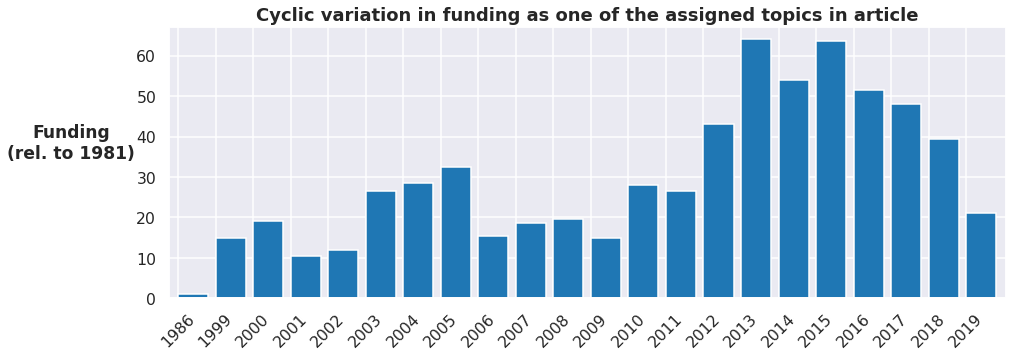

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
funds.plot(kind="bar", ax=ax, rot=45, align="edge", width=0.8)
ax.set_title(
    "Cyclic variation in funding as one of the assigned topics in article",
    fontsize=18,
    fontweight="bold",
)
ax.set_xlabel(None)
h = plt.ylabel("Funding\n(rel. to 1981)", labelpad=65, fontweight="bold")
h.set_rotation(0)

Next, we will show a bar chart of the number of words in the `"text"` of the article
- this will approximate the length of articles over the years investigated
- this will approximate the public interest in changes in this topic over the years investigated
  - if public interest decreases with time, it could be assumed to result in shorter articles

In [29]:
df["article_chars"] = df["text"].str.split().str.len()
word_count = df[["article_chars", "year"]].groupby(["year"])["article_chars"].sum()

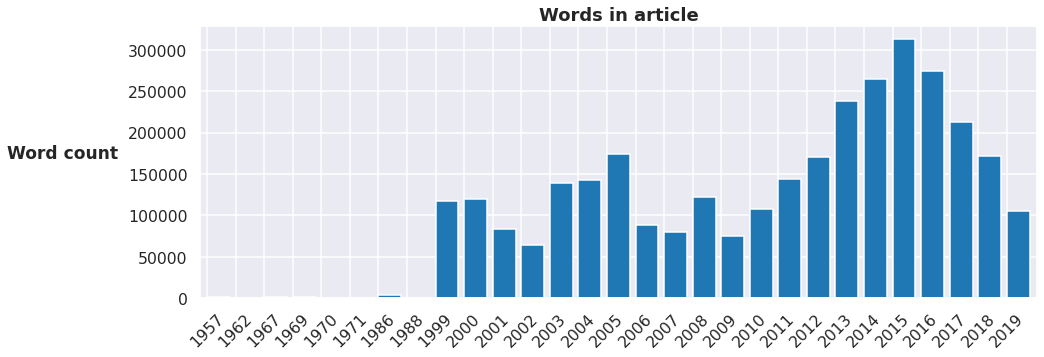

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
word_count.plot(kind="bar", ax=ax, rot=45, align="edge", width=0.8)
ax.set_title(
    "Words in article", fontsize=18, fontweight="bold",
)
ax.set_xlabel(None)
h = plt.ylabel("Word count", labelpad=65, fontweight="bold")
h.set_rotation(0)

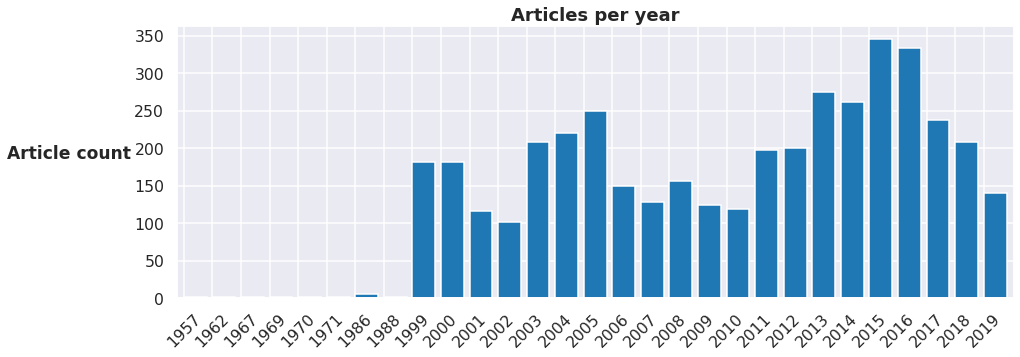

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
df["year"].value_counts().sort_index().plot(
    kind="bar", ax=ax, rot=45, align="edge", width=0.8
)
ax.set_title(
    "Articles per year", fontsize=18, fontweight="bold",
)
ax.set_xlabel(None)
h = plt.ylabel("Article count", labelpad=65, fontweight="bold")
h.set_rotation(0)

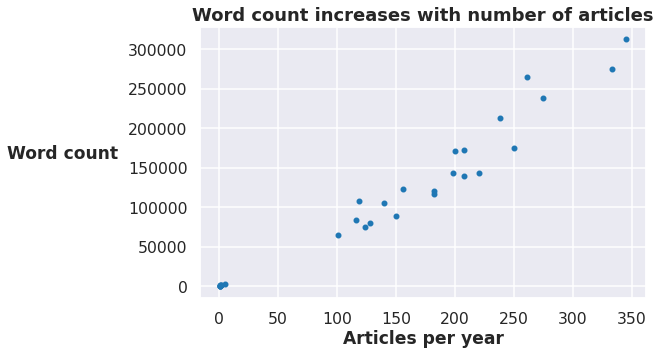

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
pd.DataFrame(word_count).merge(
    pd.DataFrame(df["year"].value_counts()),
    how="inner",
    left_index=True,
    right_index=True,
).plot.scatter(x="year", y="article_chars", ax=ax)
ax.set_title(
    "Word count increases with number of articles", fontsize=18, fontweight="bold",
)
ax.set_xlabel("Articles per year", fontweight="bold")
h = plt.ylabel("Word count", labelpad=65, fontweight="bold")
h.set_rotation(0)

For the
- New York Times
  - between 1981 and 2004, article length was fairly consistent
  - there was a significant drop in the years 2005 and 2012
  - since 2013, article length has been steadily increasing.
- Guardian
  - prior to 1999, very few articles were published and article length (from the published ones) was fairly consistently low
  - there was a drop from the years 2006 to 2010, likely coinciding to the [Great Recession](https://www.investopedia.com/terms/g/great-recession.asp)
  - since 2010, article length increased until 2015 and has been dropping since then